In [ ]:
# Depricated from Google Colab as of 2024-12-01

# !sudo apt install python3.9-full python3-pip
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1

# !pip uninstall -y scikit-learn scipy pyparsing -y
# !pip install Cython==0.29.36 scipy==1.9 pyparsing==2.4
# !pip install https://files.pythonhosted.org/packages/04/e2/b43d4205124dd4c1f14606b2e2d78303db993c6653a90bf11dd0ffe23b5b/scikit_learn-0.24.2-cp39-cp39-manylinux2010_x86_64.whl --no-build-isolation


In [2]:
import pandas as pd
import pickle
import autosklearn
from autosklearn.experimental.askl2 import AutoSklearn2Classifier

from sklearn.model_selection import train_test_split
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import autosklearn.classification
import autosklearn.metrics

from smac.optimizer.smbo import SMBO
from smac.runhistory.runhistory import RunInfo, RunValue

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
# download data from osf to data/gma_score_prediction
!wget -O osf.zip "https://files.osf.io/v1/resources/gztmd/providers/osfstorage/?zip="
!unzip -o "osf.zip" -d "data/Infant Pose Data/gma_score_prediction"


In [3]:
train_ids = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/train.csv')
val_ids = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/val.csv')
test_ids = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/test.csv')
holdout_ids = pd.read_csv('./data/Infant Pose Data/gma_score_prediction/holdout.csv')
scores = pd.read_csv('./data/gma_score_prediction_scores.csv')

In [ ]:
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create lists of IDs and labels for plotting
id_lists = [train_ids['gma_id'], val_ids['gma_id'], test_ids['gma_id'], holdout_ids['gma_id']]
labels = ['Train', 'Validation', 'Test', 'Holdout']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#f1c40f']

# Plot histograms
plt.hist(id_lists, bins=30, label=labels, color=colors, alpha=0.6)

# Customize plot
plt.title('Distribution of IDs Across Data Splits')
plt.xlabel('GMA ID')
plt.ylabel('Count')
plt.legend()

# Add count annotations
for i, (ids, label, color) in enumerate(zip(id_lists, labels, colors)):
    count = len(ids)
    plt.text(0.02, 0.95 - i*0.05, f'{label}: {count} samples', 
             transform=plt.gca().transAxes, color=color)

plt.show()

# Verify no overlap between sets
print("\nChecking for overlaps between sets:")
print(f"Train-Val overlap: {len(set(train_ids['gma_id']) & set(val_ids['gma_id']))} IDs")
print(f"Train-Test overlap: {len(set(train_ids['gma_id']) & set(test_ids['gma_id']))} IDs")
print(f"Train-Holdout overlap: {len(set(train_ids['gma_id']) & set(holdout_ids['gma_id']))} IDs")
print(f"Val-Test overlap: {len(set(val_ids['gma_id']) & set(test_ids['gma_id']))} IDs")
print(f"Val-Holdout overlap: {len(set(val_ids['gma_id']) & set(holdout_ids['gma_id']))} IDs")
print(f"Test-Holdout overlap: {len(set(test_ids['gma_id']) & set(holdout_ids['gma_id']))} IDs")


In [13]:
## Import features generated from previous notebook
features = pd.read_csv('pose_estimates/gma_score_prediction_pose_estimates/window_mean_by_feature/final/all_features.csv')
features_mean = features.groupby(['infant', 'feature'])['Value'].mean().unstack()

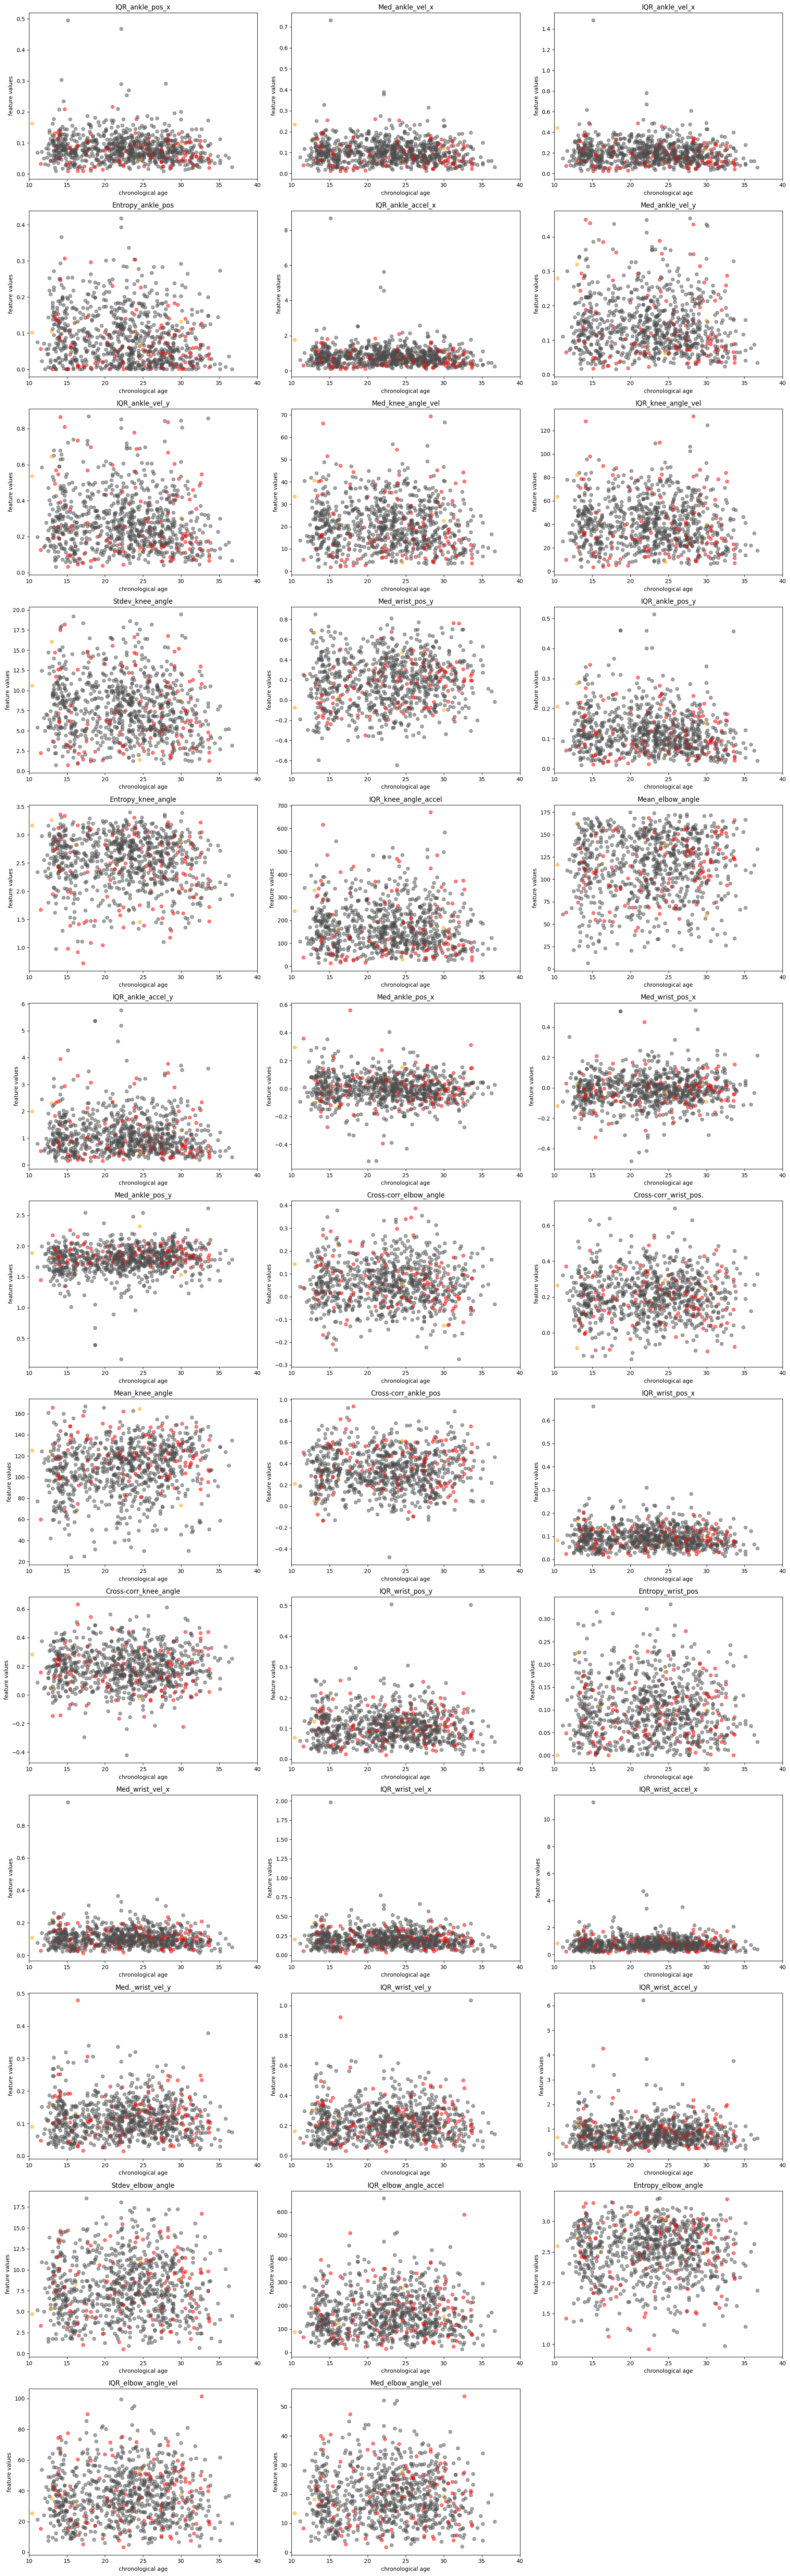

In [46]:
# plot the distribution of values for each feature as subplots
# Create subplot grid for features
feature_list = features['feature'].unique()

n_features = len(feature_list)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

#choose colorblind friendly colors for the score
colors = ['#4D4D4D', '#FF0000', '#FFA500']

plt.figure(figsize=(20, 5*n_rows))

# Plot distribution for each feature
for idx, feature in enumerate(feature_list):
    plt.subplot(n_rows, n_cols, idx+1)
    
    # Get all values for this feature
    slice = pd.merge(features_mean[feature], scores, on='infant', how='inner')
    slice.dropna(inplace=True)
    slice['score'] = slice['score'].astype(int)
    slice['score'] = slice['score'] - 1
    
    # Plot scatter plot
    plt.scatter(slice['age_chronological'], slice[feature], c=[colors[i] for i in slice['score']], alpha=0.5) 
    plt.title(feature)
    plt.xlim(10, 40)
    plt.xlabel('chronological age')
    plt.ylabel('feature values')

plt.tight_layout()
plt.show()




In [ ]:
holdout_features = features[features['infant'].isin(holdout_ids['gma_id'])]
train_features = features[features['infant'].isin(train_ids['gma_id']) | features['infant'].isin(val_ids['gma_id'])]
test_features = features[features['infant'].isin(test_ids['gma_id'])]

In [ ]:
# Get mean values for each feature per infant
features_mean = features.groupby(['infant', 'feature'])['Value'].mean().unstack()

# Create subplot grid for feature means
n_features = len(features_mean.columns)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(20, 5*n_rows))

# Plot distribution for each feature mean
for idx, feature in enumerate(features_mean.columns):
    plt.subplot(n_rows, n_cols, idx+1)
    
    # Get mean and std for this feature
    means = features_mean[feature]
    # stds = features_std[feature]
    
    # Plot histogram of means
    plt.hist(means, bins=30, alpha=0.6, color='#3498db')
    
    # set figure title
    plt.suptitle(f'Mean feature values across all infants', fontsize=16, y=1.005)

    plt.title(f'{feature.replace("_", " ")}')
    plt.xlabel('Mean Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()



In [ ]:
# plot the distribution of values for each feature

# Get unique features
unique_features = features['feature'].unique()

# Create subplot grid
n_features = len(unique_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(20, 5*n_rows))

# Plot distribution for each feature
for idx, feature in enumerate(unique_features):
    plt.subplot(n_rows, n_cols, idx+1)
    
    # Get values for this feature
    feature_vals = features[features['feature'] == feature]['Value']
    plt.suptitle(f'Feature values across all windows', fontsize=16, y=1.005)

    # Plot histogram
    plt.hist(feature_vals, bins=30, alpha=0.6, color='#3498db')
    #scale the y axis logarithmically if needed 
    plt.yscale('log')
    plt.title(feature.replace("_", " "))
    plt.xlabel('Value')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [ ]:
# plot the distribution of scores as discrete values (1, 2, 3)
plt.hist(scores['score'], bins=[0.5, 1.5, 2.5, 3.5], alpha=0.6, color='#3498db')
plt.title('Distribution of scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks([1, 2, 3])  # Set x-axis ticks to only show 1, 2, 3
plt.show()


In [ ]:
holdout_features 

In [ ]:
# plot scatter plot of chronological age vs value for each feature and color by score for each infant

for feature in features['feature'].unique():
    plt.scatter(features[features['feature'] == feature]['age_chronological'], features[features['feature'] == feature]['Value'], c=scores['score'], cmap='viridis')
    plt.title(f'{feature.replace("_", " ")}')
    plt.xlabel('Age')
    plt.ylabel('Value')
    plt.show()

In [ ]:

pivot_df = features.pivot_table(index='infant', columns=['feature'], values='Value', fill_value=np.nan)
risk_df = features[['infant', 'risk']].drop_duplicates()


In [ ]:

test_pivot_df = test_features.pivot_table(index='infant', columns=['feature'], values='Value', fill_value=0)
test_risk_df = test_features[['infant', 'risk']].drop_duplicates()

holdout_pivot_df = holdout_features.pivot_table(index='infant', columns=['feature'], values='Value', fill_value=np.nan)
holdout_risk_df = holdout_features[['infant', 'risk']].drop_duplicates()

train_df = pd.merge(pivot_df, risk_df, on='infant', how='inner')
test_df = pd.merge(test_pivot_df, test_risk_df, on='infant', how='inner')
holdout_df = pd.merge(holdout_pivot_df, holdout_risk_df, on='infant', how='inner')

X = train_df.drop(columns=['infant', 'risk'])
y = train_df['risk']

X_test = test_df.drop(columns=['infant', 'risk'])
y_test = test_df['risk']

X_holdout = holdout_df.drop(columns=['infant', 'risk'])
y_holdout = holdout_df['risk']

In [ ]:
automl = AutoSklearn2Classifier(
    ensemble_size=1,
    dataset_compression=False,
    allow_string_features=False,
    time_left_for_this_task=300,
    per_run_time_limit=30,
    metric=autosklearn.metrics.balanced_accuracy,
    delete_tmp_folder_after_terminate=False,
    memory_limit=None,
    disable_evaluator_output=False,
)

automl.fit(X, y)
probabilities = automl.predict_proba(X_holdout)[:, 1]

In [ ]:
!wget --content-disposition --max-redirect=20 https://osf.io/download/xa43g/
model = pickle.load(open('automl_vanilla_gma_prediction.pkl', 'rb'))
